In [31]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import fcluster
import pandas as pd
import numpy as np

In [7]:
regions_datadir = "/data/uscuni-ulce/"
morphotopes_dir = '/data/uscuni-ulce/processed_data/morphotopes/'
model_params = '_100_0_None_None_False'

In [8]:
to_drop = [
        'stcSAl','stbOri','stcOri','stbCeA',
        'ldkAre', 'ldkPer', 'lskCCo', 'lskERI','lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'likWCe',
# 'sdbAre', 'ssbCCM', 'sdcLAL'
    # 'mibCCo', 'mibLAL'
]

In [9]:
region_id = 69333


In [21]:
data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
data.index = str(region_id) + '_' + data.index
data = data.iloc[:, :-1]

In [22]:
component_data = data.drop(columns=['percentile_25', 'percentile_75', 'median', 'std'], level=1)
component_data = component_data.drop(columns=to_drop, level=0)
component_data.columns =  ['_'.join(col).strip() for col in component_data.columns.values]

In [32]:
vals = StandardScaler().fit_transform(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
component_data = component_data.drop(component_data.columns[component_data.std() == 0], axis=1)

# component_data = component_data[component_data.index >= 0]
vals = np.nan_to_num(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)


In [67]:

linkage = 'ward'
metric = 'euclidean'

from sklearn.cluster import AgglomerativeClustering
from core.cluster_validation import get_linkage_matrix
clusterer = AgglomerativeClustering(linkage=linkage,
                                    metric=metric,
                                    compute_full_tree=True,
                                    compute_distances=True)
model = clusterer.fit(component_data.values)
linkage_matrix = get_linkage_matrix(model)

In [51]:
import sys
sys.setrecursionlimit(10000)

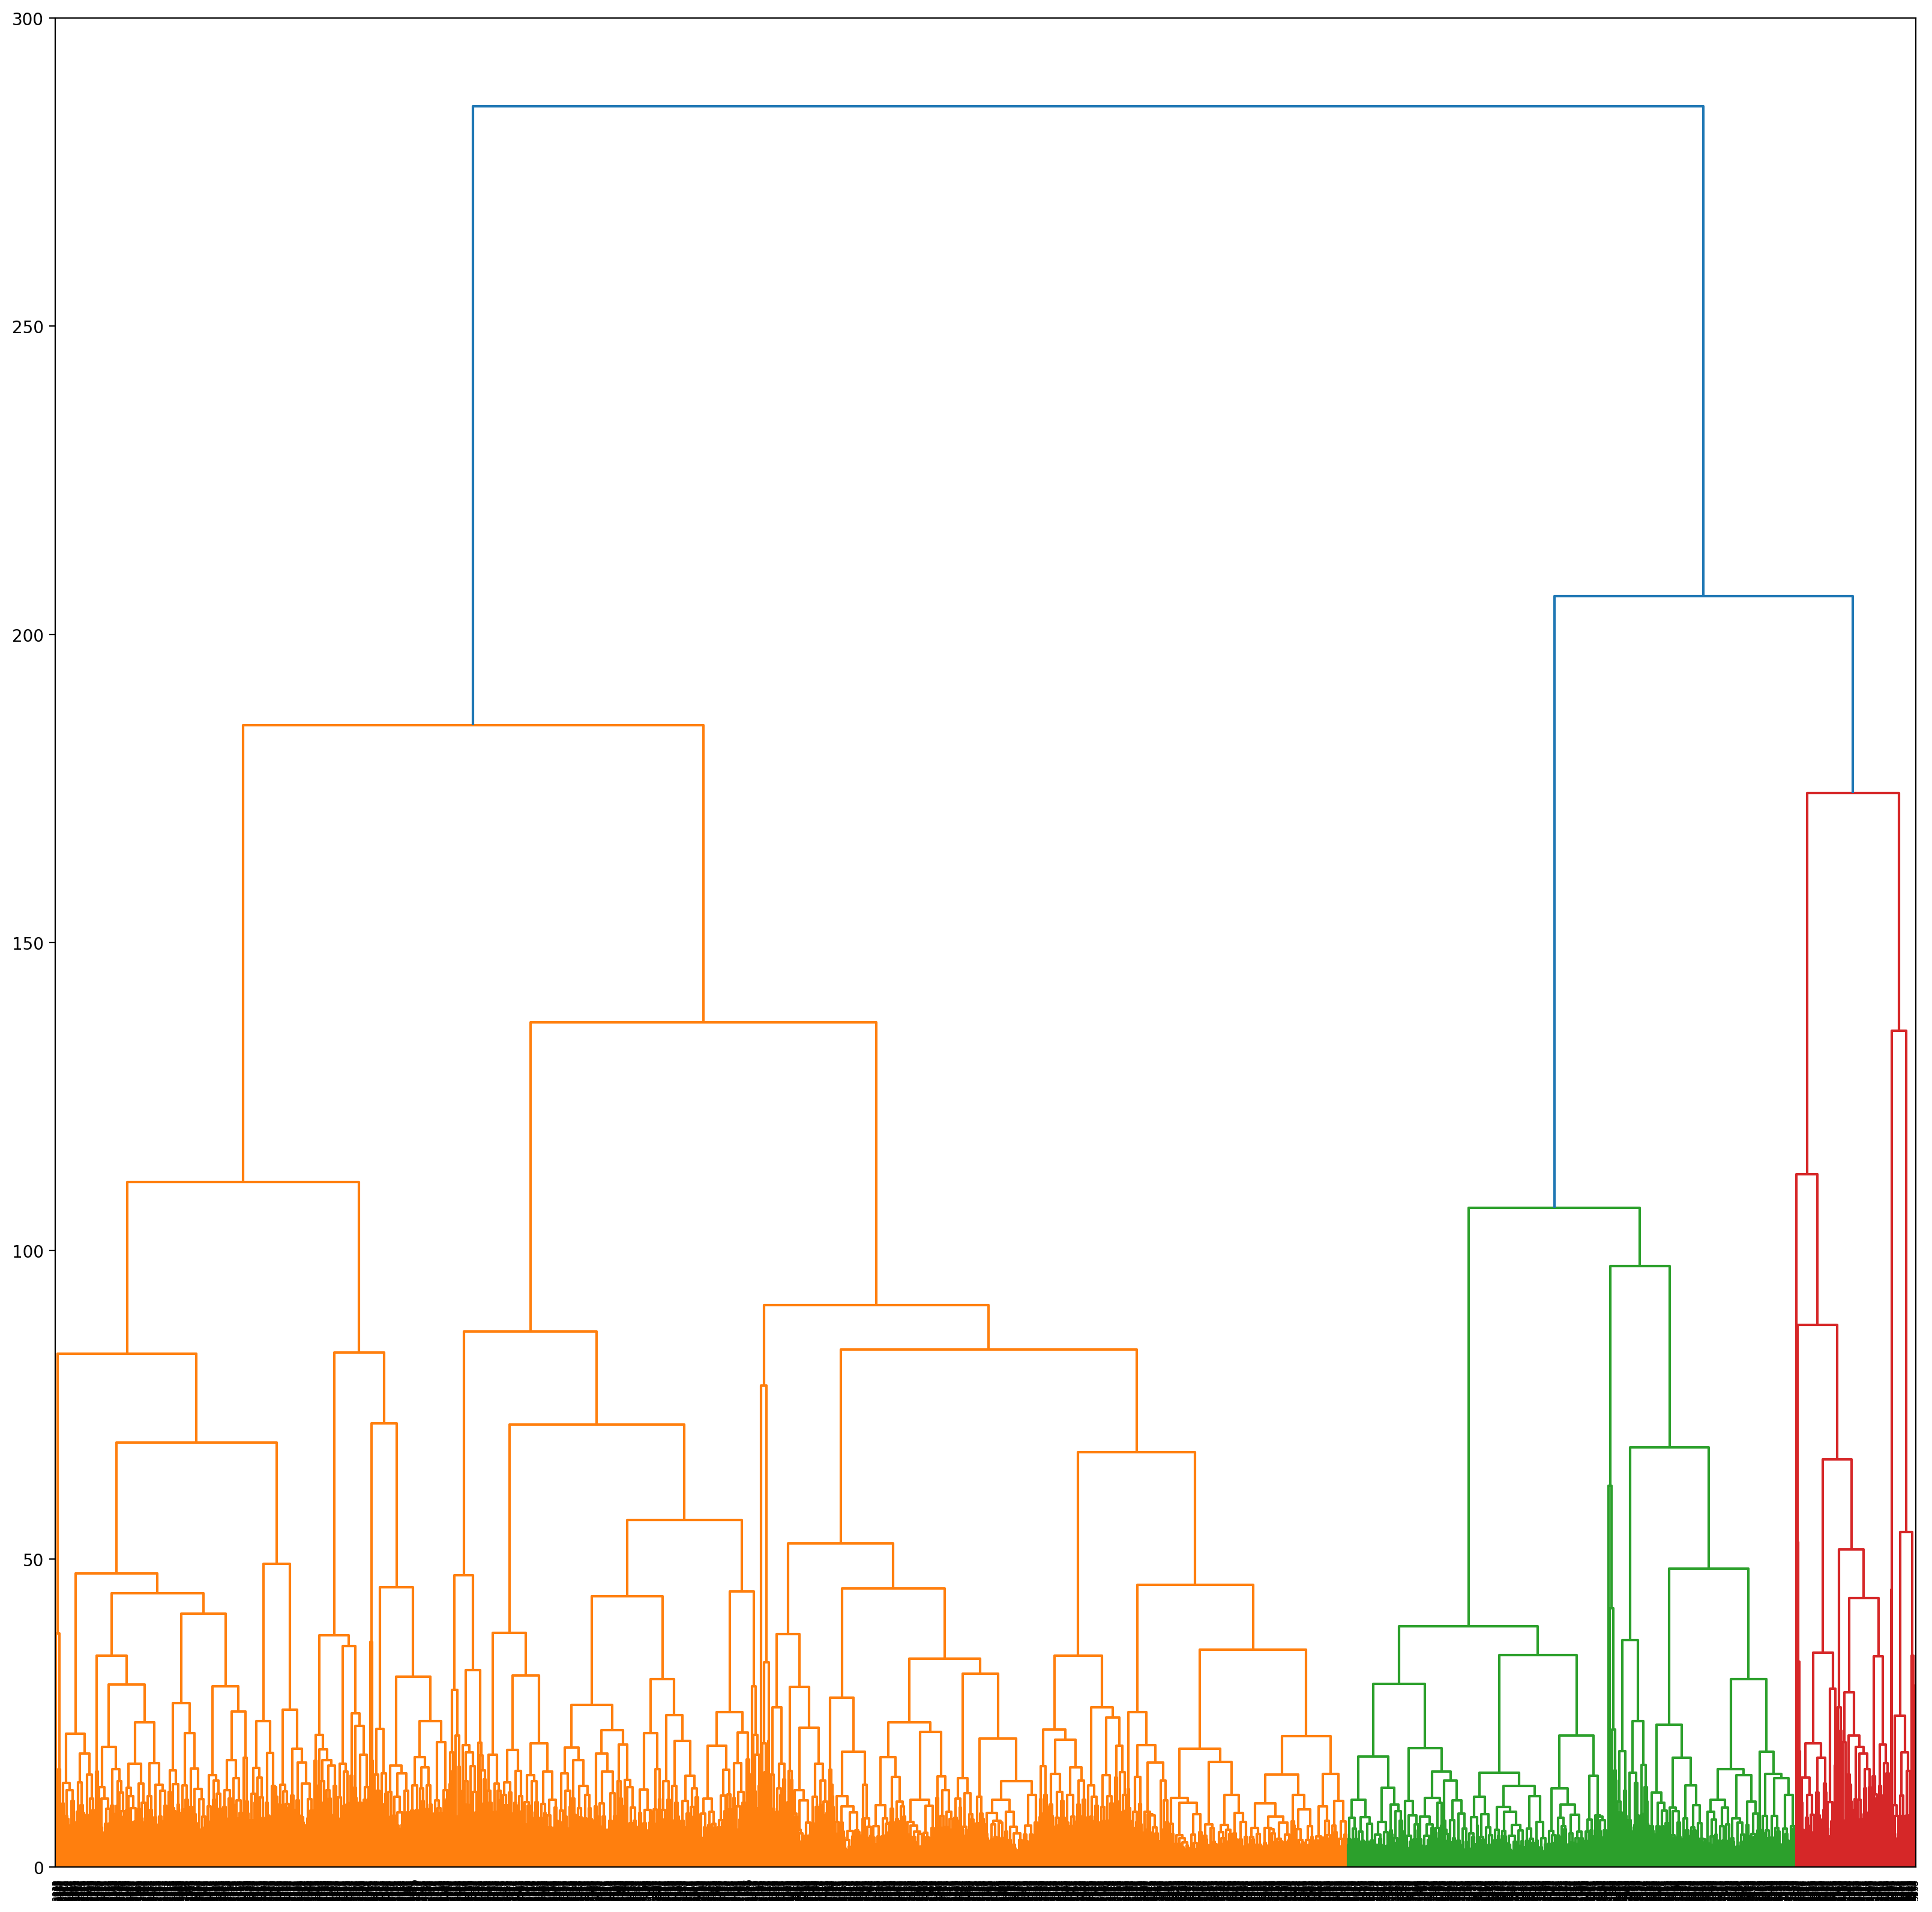

In [70]:
fig,ax = plt.subplots(figsize=(20,20), dpi=200)
_ = dendrogram(linkage_matrix,ax=ax)

In [71]:
# import matplotlib.pyplot as plt
# from scipy.cluster.hierarchy import dendrogram, fcluster
# from hdbscan.plots import SingleLinkageTree

# fig,ax = plt.subplots(figsize=(20,20), dpi=200)

# fig, ax = plt.subplots(figsize=(20,10))
# SingleLinkageTree(linkage_matrix).plot(axis=ax)

In [72]:
R = dendrogram(linkage_matrix, no_plot=True)


In [93]:
R['ivl'][R['leaves'][component_data.shape[0]-1]]

'5095'

In [109]:
ii = np.argsort(np.array(R['dcoord'])[:, 1])

In [121]:
ii

array([4329, 4185, 4231, ..., 3758, 5410, 5411])

In [164]:
### fast way to find out where in ii, each node is equivalent to np.nonzero(ii == j)
sorter = np.argsort(ii)
positions = sorter[np.searchsorted(ii, np.arange(0, len(R['dcoord'])), sorter=sorter)]
nodes = linkage_matrix[positions, ] 
nodes = nodes[:, [0,1]] # keep both parent and child node

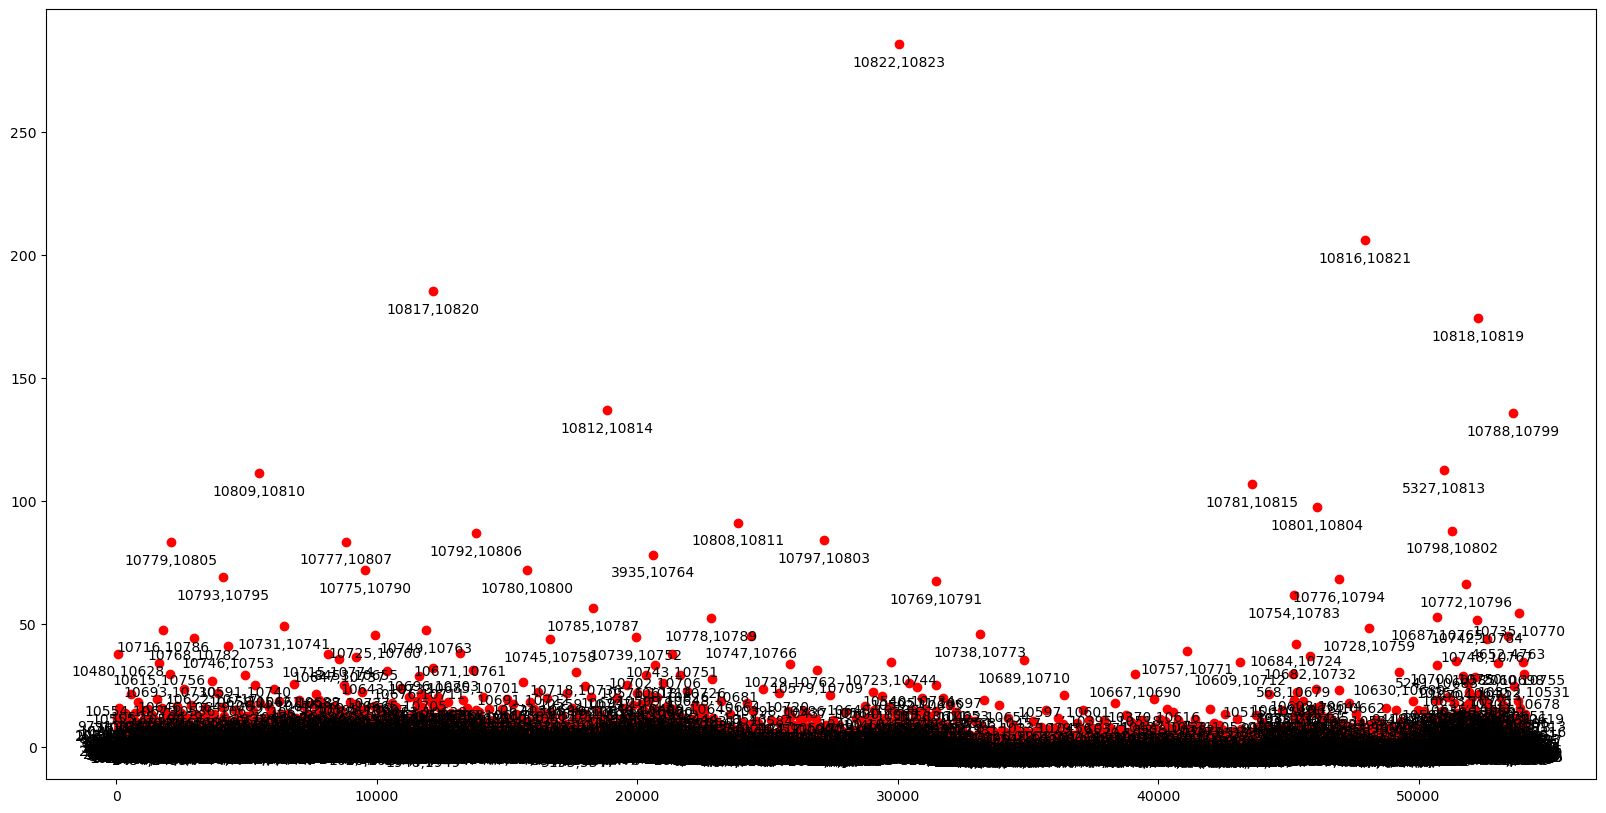

In [167]:
fig, ax = plt.subplots(figsize=(20,10))

for (node, i, d) in zip(nodes, R['icoord'], R['dcoord']):
    x = 0.5 * sum(i[1:3])
    y = float(d[1])
    ax.plot(x, y, 'ro')
    ax.annotate(str(int(node[0])) + ',' + str(int(node[1])), (x, y), xytext=(0, -8),
                         textcoords='offset points',
                         va='top', ha='center')

In [148]:
import numpy as np

def get_original_observations(Z, node_id, n):
    """
    Recursively retrieves all original observations that belong to a cluster node.

    Parameters:
    Z : numpy.ndarray
        Linkage matrix of shape (n-1, 4) where each row [Z[i, 0], Z[i, 1], Z[i, 2], Z[i, 3]]
        contains two merged clusters and additional metadata.
    node_id : int
        The node (cluster) ID for which to retrieve original observations.
    n : int
        The total number of original observations.

    Returns:
    observations : list
        List of original observation indices that are part of the specified node_id.
    """
    # If the node_id refers to an original observation, return it
    if node_id < n:
        return [node_id]
    
    # Otherwise, recursively find observations for the two merged clusters
    cluster_idx = node_id - n # Adjust the index because new clusters start from n
    
    left_cluster = int(Z[cluster_idx, 0])
    right_cluster = int(Z[cluster_idx, 1])
    
    left_observations = get_original_observations(Z, left_cluster, n)
    right_observations = get_original_observations(Z, right_cluster, n)
    
    return left_observations + right_observations





# def dendogram_idx_nodes(idx, node_id, linkage, n_children, out=[]):
    
#     if node_id < 0:
#        return
#     left, right = linkage[idx]
#     out.append((idx, node_id))
#     # recurse over the right node
#     if right >= n_children: # make sure it's not a leaf node
#         node_id -= 1
#         node_id = dendogram_idx_nodes(right - (n_children + 1), node_id,
#                                      linkage, n_children, out)
#     if left >= n_children: # make sure it's not a leaf node
#         node_id -= 1
#         node_id = dendogram_idx_nodes(left - (n_children +1), node_id,
#                                      linkage, n_children, out)
#     return node_id

In [173]:
def get_children(left, right):
    res1 = get_original_observations(linkage_matrix, left, component_data.shape[0])
    res2 = get_original_observations(linkage_matrix, right, component_data.shape[0])
    res = np.union1d(res1, res2)
    return res

In [178]:
assert get_children(int(linkage_matrix[123, 0]), int(linkage_matrix[123, 1])).shape[0] == linkage_matrix[123, 3]
assert get_children(int(linkage_matrix[4321, 0]), int(linkage_matrix[4321, 1])).shape[0] == linkage_matrix[4321, 3]
assert get_children(int(linkage_matrix[-1, 0]), int(linkage_matrix[-1, 1])).shape[0] == linkage_matrix[-1, 3]


In [169]:
linkage_matrix

array([[3.39900000e+03, 4.59400000e+03, 1.00990518e+00, 2.00000000e+00],
       [6.79000000e+02, 4.53700000e+03, 1.01311410e+00, 2.00000000e+00],
       [1.40400000e+03, 4.60200000e+03, 1.04402678e+00, 2.00000000e+00],
       ...,
       [1.08170000e+04, 1.08200000e+04, 1.85314585e+02, 3.76000000e+03],
       [1.08160000e+04, 1.08210000e+04, 2.06220802e+02, 1.65300000e+03],
       [1.08220000e+04, 1.08230000e+04, 2.85720093e+02, 5.41300000e+03]])

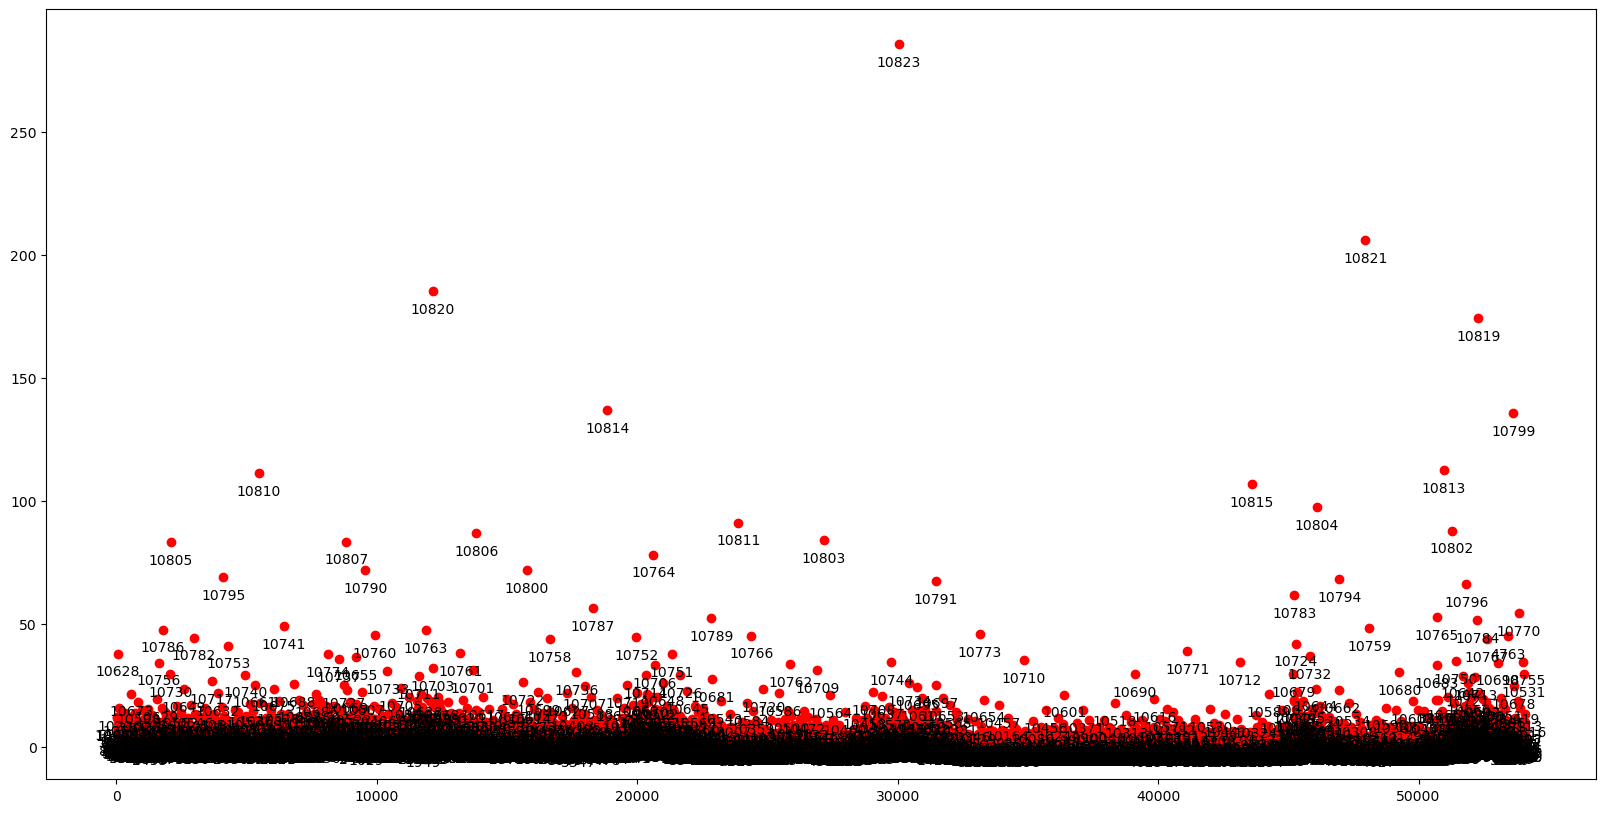

In [120]:
fig, ax = plt.subplots(figsize=(20,10))

for j, (i, d) in enumerate(zip(R['icoord'], R['dcoord'])):
    x = 0.5 * sum(i[1:3])
    y = float(d[1])
    ax.plot(x, y, 'ro')

    node = linkage_matrix[np.nonzero(ii == j)[0][0]][1]
    
    ax.annotate(str(int(node)), (x, y), xytext=(0, -8),
                         textcoords='offset points',
                         va='top', ha='center')

In [76]:
component_data.shape

(5413, 59)

In [83]:
from scipy.cluster.hierarchy import linkage, dendrogram, to_tree

In [82]:
linkage_matrix[n]

array([ 9738.        , 10214.        ,    11.50243621,    19.        ])